# Doublets versus singlets

This notebook will attempt a numerical comparison of doublet and singlet lenses.
The advantages of doublet lenses are described well in the applications tab of [this Thorlab's page](https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=120).
Let's try to reproduce those claims!

In [22]:
from rayoptics.environment import *
import matplotlib.pyplot as plt
import numpy as np

## Create the optical systems

We start by defining the optical systems used for our analysis.
The object plane is at infinity.
For the doublet, we use lens AC127-050-A.

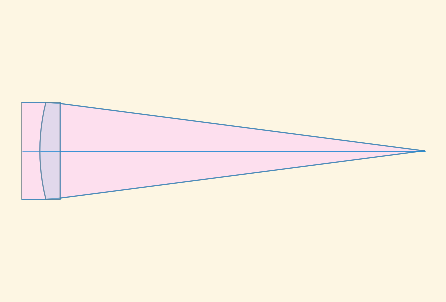

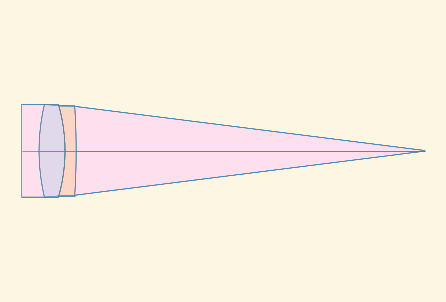

In [60]:
def singlet_lens_system(image_distance, object_radial, wavelengths):
    opm = OpticalModel()
    sm  = opm.seq_model
    osp = opm.optical_spec
    pm = opm.parax_model

    osp.pupil = PupilSpec(osp, key=['object', 'pupil'], value=12.5)
    osp.field_of_view = FieldSpec(osp, key=['object', 'height'], flds=[object_radial])
    osp.spectral_region = WvlSpec(wavelengths, ref_wl=0)
    opm.radius_mode = True
    lens_thickness = 2.6
    lens_R = 51.1/2.0

    sm.gaps[0].thi=1e10
    sm.add_surface([lens_R, lens_thickness, 'N-BK7', 'Schott'])
    sm.set_stop()
    sm.add_surface([1e10, image_distance])
    opm.update_model()
    return opm

def doublet_lens_system(image_distance, object_radial, wavelengths):
    opm = OpticalModel()
    sm  = opm.seq_model
    osp = opm.optical_spec
    pm = opm.parax_model

    osp.pupil = PupilSpec(osp, key=['object', 'pupil'], value=12.5)
    osp.field_of_view = FieldSpec(osp, key=['object', 'height'], flds=[object_radial])
    osp.spectral_region = WvlSpec(wavelengths, ref_wl=0)

    opm.radius_mode = True

    sm.gaps[0].thi= 1e10
    sm.add_surface([27.4, 3.5, 'N-BK7', 'Schott'])
    sm.add_surface([-22.5, 1.5, 'SF2', 'Schott'])
    sm.set_stop()
    sm.add_surface([-91.8, image_distance])
    #sm.add_surface([91.8, 1.5, 'SF2', 'Schott'])
    #sm.add_surface([22.5, 3.5, 'N-BK7', 'Schott'])
    #sm.add_surface([-27.4, image_distance])    
    opm.update_model()
    return opm

model = singlet_lens_system(47.0, 0.0, [(587.5618, 1.0)])
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=model, do_draw_rays=True, do_paraxial_layout=False).plot()

model = doublet_lens_system(47.0, 0.0, [(587.5618, 1.0)])
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=model, do_draw_rays=True, do_paraxial_layout=False).plot()

# Achieve a tighter focus

We calculate the smallest circle of least confusion for both imaging systems.

(Much of this code follows the principles behind the [spot diagram calculations](https://github.com/mjhoptics/ray-optics/blob/73a697af89420b02295c0a7ac49b209b86ff3320/src/rayoptics/mpl/axisarrayfigure.py).

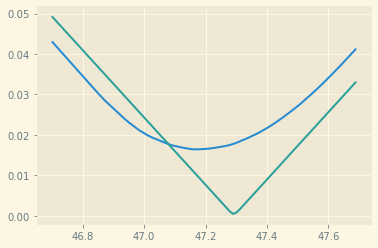

min_singlet=16.44um
min_doublet=0.47um
ratio=35.01


In [61]:
def get_spot_size(opt_model):
    seq_model = opt_model.seq_model
    osp = opt_model.optical_spec
    # get 0th field and wavelength.
    fld, wvl, foc = osp.lookup_fld_wvl_focus(0, wl=0)
    
    def spot(p, wi, ray_pkg, fld, wvl, foc):
        if ray_pkg is not None:
            image_pt = fld.ref_sphere[0]
            ray = ray_pkg[mc.ray]
            dist = foc / ray[-1][mc.d][2]
            defocused_pt = ray[-1][mc.p] - dist*ray[-1][mc.d]
            t_abr = defocused_pt - image_pt
            return np.array([t_abr[0], t_abr[1]])
        else:
            return None
    
    (points, _) = seq_model.trace_grid(spot, 0, num_rays=21, form='list', append_if_none=False)
    x = np.transpose(points)[0]
    y = np.transpose(points)[1]
    #plt.scatter(x,y)
    r = np.power(np.power(x,2) + np.power(y,2), 0.5)
    return np.mean(r)

def get_singlet_spot_size(image_distance):
    model = singlet_lens_system(image_distance, 0.0, [(587.5618, 1.0)])
    return get_spot_size(model)

def get_doublet_spot_size(image_distance):
    model = doublet_lens_system(image_distance, 0.0, [(587.5618, 1.0)])
    return get_spot_size(model)

distances = np.arange(46.7, 47.7, 0.01)
radii = [get_singlet_spot_size(d) for d in distances]
min_singlet = np.min(radii)
plt.plot(distances, radii)

radii = [get_doublet_spot_size(d) for d in distances]
plt.plot(distances, radii)
min_doublet = np.min(radii)
plt.show()

print("min_singlet={:.2f}um".format(1e3*min_singlet))
print("min_doublet={:.2f}um".format(1e3*min_doublet))
print("ratio={:.2f}".format(min_singlet/min_doublet))

We record a ratio of 35x improvement!
_Note that our beam is much wider than that used in the Thorlabs page - if I reduce the beam down to 5mm radius, I get a factor of 6 difference, which is closer to their value. Also, the wavelength used is different._

Near the focus, the spot diagrams are:

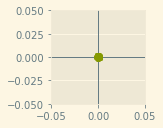

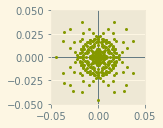

In [68]:
def set_limits(fig):
    fig.set_size_inches(1.5,1.5)
    for ax in fig.get_axes():
        ax.set_ylim(-0.05,0.05)
        ax.set_xlim(-0.05,0.05)
    return fig

model = doublet_lens_system(47.28, 0.0, [(587.5618, 1.0)])
p = set_limits(plt.figure(FigureClass=SpotDiagramFigure, opt_model=model).plot())

model = singlet_lens_system(47.2, 0.0, [(587.5618, 1.0)])
p = set_limits(plt.figure(FigureClass=SpotDiagramFigure, opt_model=model).plot())

This clearly demonstrates that the doublet has a tighter focusing ability than the singlet.

_As a cautionary note, I remind the reader that this does **not** consider diffraction. For very small spot sizes diffraction will become a significant effect_.